In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ls

asl_laser@              pointfusion.py
asl_parser.ipynb        pointfusion_scannet.py
depth_correction.ipynb  RenderOption_2021-09-17-13-09-50.json
icpslam.py              rgbd_pcd_normals.ipynb
icpslam_scannet.py      rgbd_pcd_normals.py
optimization.ipynb      tutorials/
pointfusion.ipynb


In [3]:
world = 'eth'

### Ground trith pose of Scanner

In [4]:
pose_scanner_leica =  pd.read_csv(f'asl_laser/{world}/leica/pose_scanner_leica.csv')

In [5]:
T00 = pose_scanner_leica[' T00']
T01 = pose_scanner_leica[' T01']
T02 = pose_scanner_leica[' T02']
T03 = pose_scanner_leica[' T03']
T10 = pose_scanner_leica[' T10']
T11 = pose_scanner_leica[' T11']
T12 = pose_scanner_leica[' T12']
T13 = pose_scanner_leica[' T13']
T20 = pose_scanner_leica[' T20']
T21 = pose_scanner_leica[' T21']
T22 = pose_scanner_leica[' T22']
T23 = pose_scanner_leica[' T23']
T30 = pose_scanner_leica[' T30']
T31 = pose_scanner_leica[' T31']
T32 = pose_scanner_leica[' T32']
T33 = pose_scanner_leica[' T33']

N = len(T00)
T = []
for i in range(N):
    t = [[T00[i], T01[i], T02[i], T03[i]],
         [T10[i], T11[i], T12[i], T13[i]],
         [T20[i], T21[i], T22[i], T23[i]],
         [T30[i], T31[i], T32[i], T33[i]]]
    T.append(t)
T = np.asarray(T)

assert T.shape == (N, 4, 4)

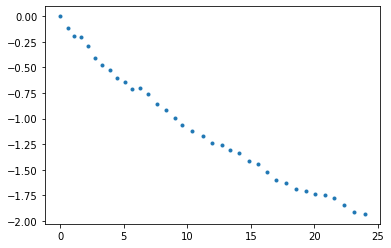

In [6]:
plt.plot(T[:, 0, 3], T[:, 1, 3], '.')

### Load point clouds

In [7]:
import os
import open3d as o3d
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('/home/ruslan/subt/thirdparty/Open3D/examples/python/')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample2.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/cube.obj already exists

In [9]:
# pcs = [pd.read_csv(f'asl_laser/{world}/csv_global/PointCloud{i}.csv') for i in range(N)]
pcs = [pd.read_csv(f'asl_laser/{world}/csv_local/Hokuyo_{i}.csv') for i in range(N)]

In [10]:
i = np.random.choice(N)
pts = np.asarray([pcs[i]['x'], pcs[i]['y'], pcs[i]['z']]).T
assert pts.shape[1] == 3

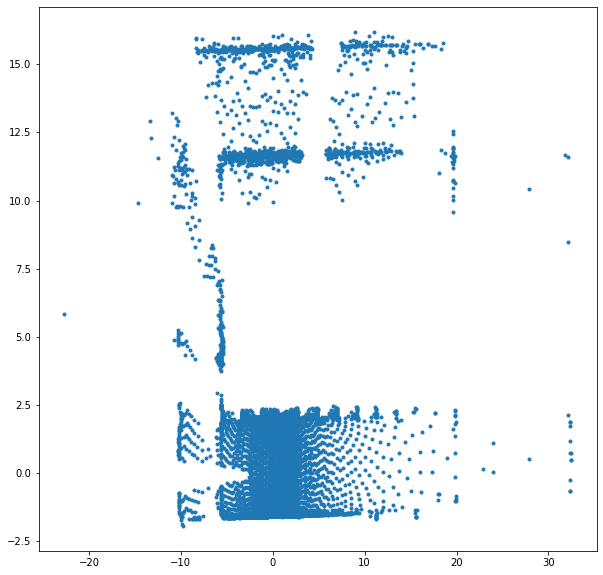

In [11]:
plt.figure(figsize=(10, 10))
# plt.plot(pcs[0]['x'][::10], pcs[0]['y'][::10], '.')
plt.plot(pts[:, 0][::10], pts[:, 1][::10], '.')

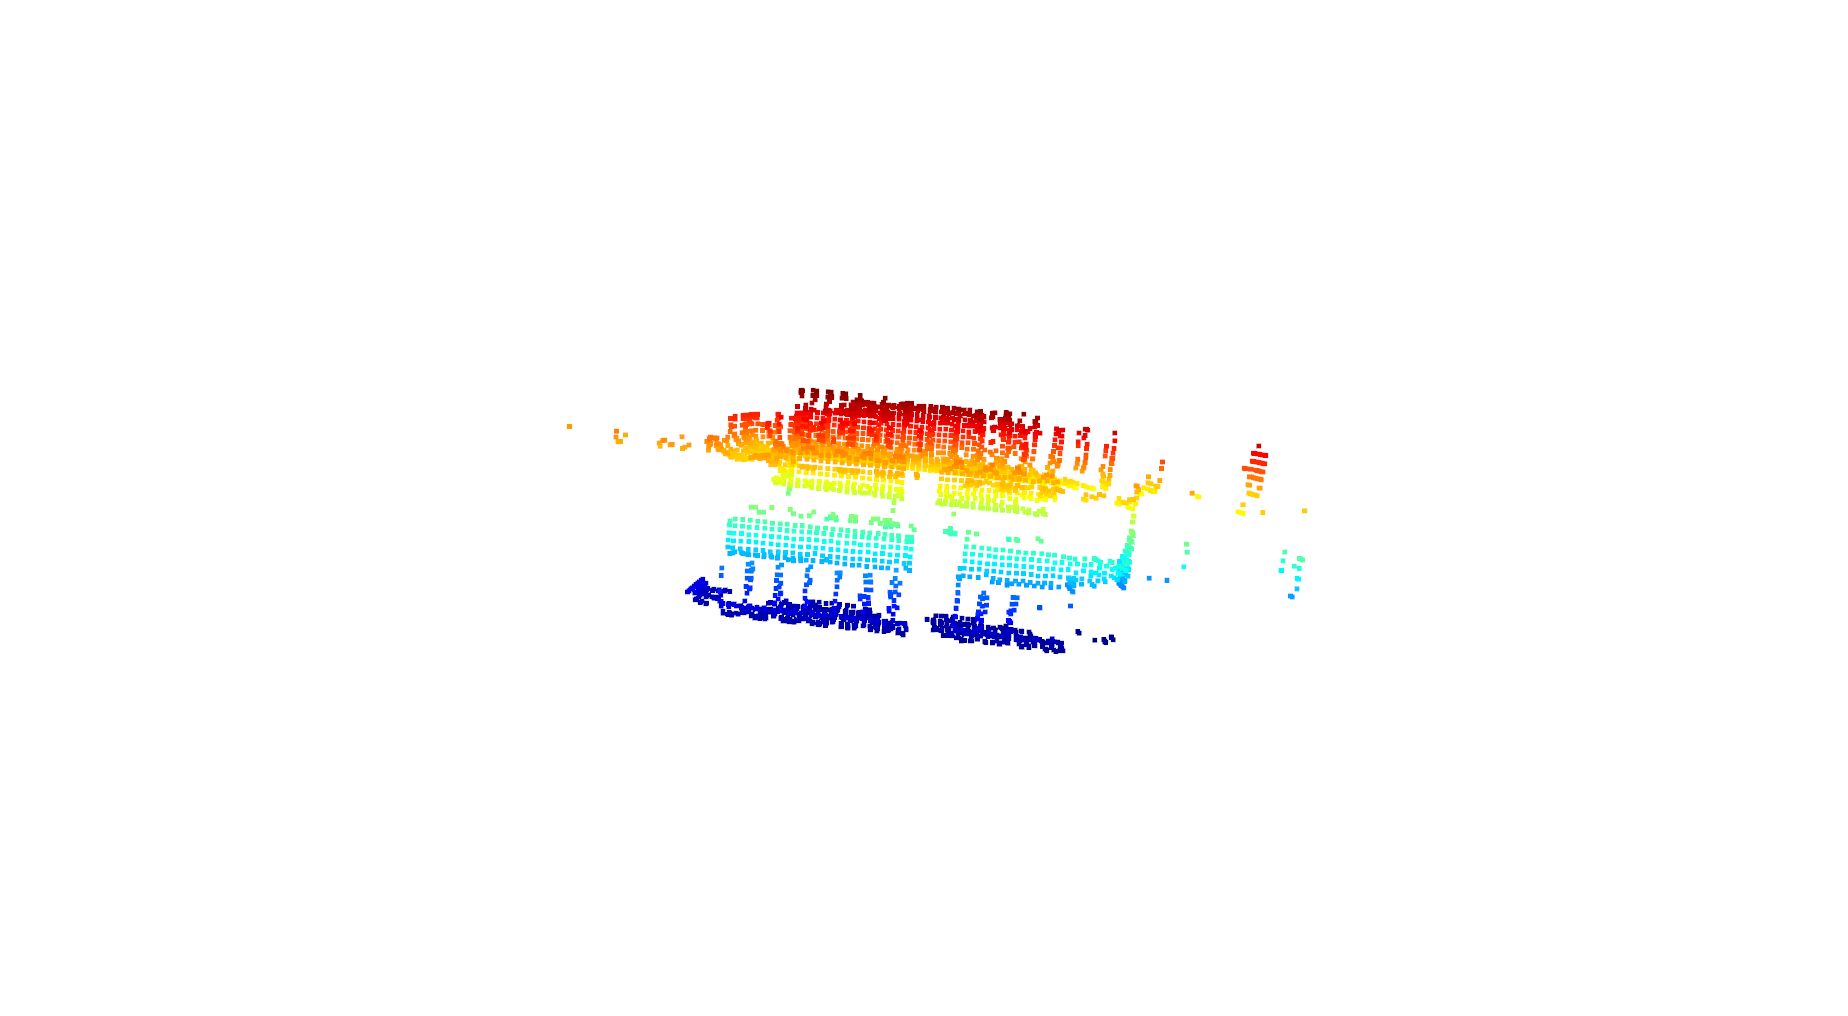

In [15]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
pcd = pcd.voxel_down_sample(voxel_size=0.5)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

o3d.visualization.draw_geometries([pcd])

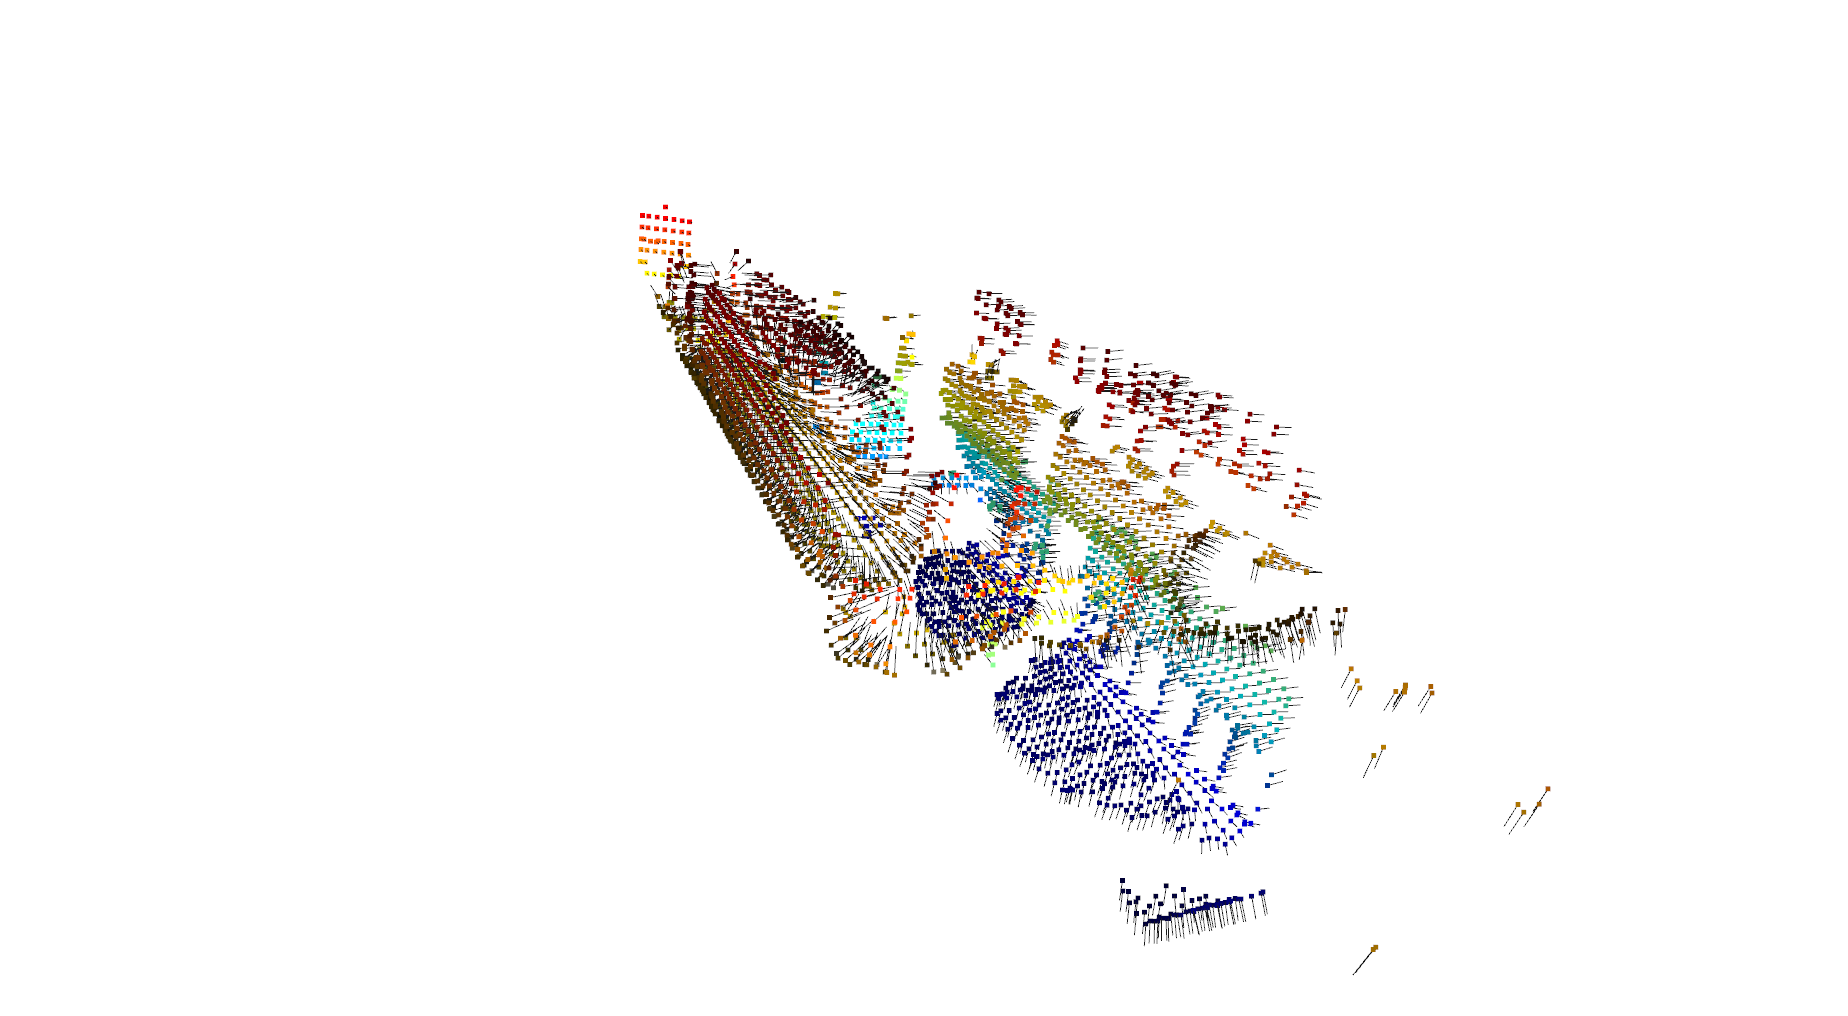

In [25]:
pcd.estimate_normals()
pcd.normalize_normals()
pcd.normals = o3d.utility.Vector3dVector(np.asarray(pcd.normals) / 4.)
pcd.orient_normals_consistent_tangent_plane(k=15)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

### Construct global map from sequence of local ones